#### <h1><center>CMSC 478: Introduction to Machine Learning</center></h1>

<center><img src="img/title.jpg" align="center"/></center>


<h3 style="color:blue;"><center>Instructor: Fereydoon Vafaei</center></h3>


<h5 style="color:purple;"><center>Training Deep Neural Networks</center></h5>

<center><img src="img/UMBC_logo.png" align="center"/></center>

<h1><center>Agenda</center></h1>

- <b>Training Deep Neural Networks</b>
    - Vanishing and Exploding Gradients
    - Glorot and He initialization
    - Dying Neurons
    - Nonsaturating Activation Functions
        - Leaky ReLU
        - ELU
        - SELU
    - Batch Normalization
    - Gradient Clipping
    - Transfer Learning
    - Unsupervised Pretraining
    - Faster Optimizers
    - Learning Rate Scheduling
    - Regularization and Dropout

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import tensorflow as tf
from tensorflow import keras

<h1><center>Vanishing and Exploding Gradients</center></h1>

- During training DNNs, gradients often get smaller and smaller as the algorithm progresses down to the lower layers.


- As a result, the Gradient Descent update leaves the lower layers’ connection weights virtually unchanged, and training never converges to a good solution. This is called the **vanishing gradients** problem.


- In some cases, the opposite can happen: the gradients can grow bigger and bigger until layers get insanely large weight updates and the algorithm diverges. This is the **exploding gradients** problem, which surfaces in **Recurrent Neural Networks (RNN)**.


- More generally, DNNs suffer from **unstable gradients**; different layers may learn at widely different speeds.

<h1><center>Logistic Function Saturation</center></h1>

<center><img src="img/saturation.png" align="center"/></center>

<font size='1'>Image from Ref[1]</font>

<h1><center>Glorot and He Initialization</center></h1>

- In their paper, Glorot and Bengio propose a way to significantly alleviate the unstable gradients problem.


- They point out that we need the signal to flow properly in both directions: in the forward direction when making predictions, and in the reverse direction when backpropagating gradients.


- We don’t want the signal to die out, nor do we want it to explode and saturate.


- For the signal to flow properly, the authors argue that we need the variance of the outputs of each layer to be equal to the variance of its inputs, and we need the gradients to have equal variance before and after flowing through a layer in the reverse direction.

<h1><center>Glorot and He Initialization Equations</center></h1>

- The connection weights of each layer must be initialized randomly as described in Equation 11-1, where $fan_{in}$ is the number of inputs of the layer and $fan_{out}$ is the number of neurons of the layer and 
$fan_{avg} = (fan_{in} + fan_{out})/2$.


- This initialization strategy is called **Xavier initialization** or **Glorot initialization**, after the paper’s first author.

<center><img src="img/glorot.png" align="center"/></center>

<h1><center>Initialization Summary</center></h1>

- By default, Keras uses **Glorot** initialization with a uniform distribution.

<center><img src="img/init.png" align="center"/></center>

<font size='1'>Table from Ref[1]</font>

In [2]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'Identity',
 'Initializer',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'serialize',
 'zeros']

In [ ]:
# Example of changing the initialization method
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

# Example of changing the parameters of the initialization method
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

<h1><center>Dying Neurons and Nonsaturating Activation Functions</center></h1>

- The ReLU activation function is not perfect. It suffers from a problem known as the **dying ReLUs** (or dying neurons): during training, some neurons effectively “die,” meaning they stop outputting anything other than 0.


- In some cases, you may find that half of your network’s neurons are dead, especially if you used a large learning rate.


- A neuron dies when its weights get tweaked in such a way that the weighted sum of its inputs are negative for all instances in the training set. When this happens, it just keeps outputting zeros, and Gradient Descent does not affect it anymore because the gradient of the ReLU function is zero when its input is negative.


- To solve this problem, you may want to use a variant of the ReLU function, such as the **leaky ReLU**.

[-5, 5, -0.5, 4.2]

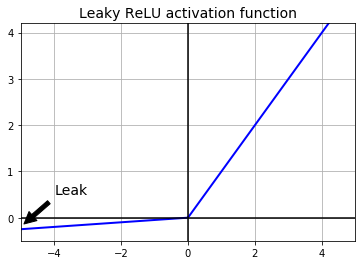

In [3]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)
z = np.linspace(-5, 5, 200)
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

In [6]:
# Activation functions in keras
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'tanh']

**Equation 11-2: ELU activation function**

$
\operatorname{ELU}_\alpha(z) =
\begin{cases}
\alpha(\exp(z) - 1) & \text{if } z < 0\\
z & if z \ge 0
\end{cases}
$

[-5, 5, -2.2, 3.2]

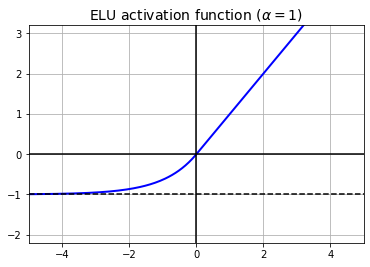

In [7]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

<h1><center>ELU Properties</center></h1>

- ELU takes on negative values when z < 0, which allows the unit to have an average output closer to 0 and helps alleviate the **vanishing gradients** problem.
    - The hyperparameter α defines the value that the ELU function approaches when z is a large negative number.
    - It is usually set to 1, but you can tweak it like any other hyperparameter.


- It has a nonzero gradient for z < 0, which avoids the **dead neurons** problem.


- If α is equal to 1 then the function is smooth everywhere, including around z = 0, which helps speed up Gradient Descent since it does not bounce as much to the left and right of z = 0.


- The main drawback of the ELU activation function is that it is slower to compute than the ReLU function and its variants (due to the use of the exponential function).


- Its faster convergence rate during training compensates for that slow computation, but still, at test time an ELU network will be slower than a ReLU network.

<h1><center>SELU</center></h1>

- SELU is a scaled variant of the ELU activation function.


- The authors showed that if you build a neural network composed exclusively of a stack of dense layers, and if all hidden layers use the SELU activation function, then the network will self-normalize: the output of each layer will tend to preserve a mean of 0 and standard deviation of 1 during training, which solves the **vanishing/exploding gradients** problem.


- As a result, the SELU activation function often significantly outperforms other activation functions for such neural nets (especially deep ones).

In [8]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

[-5, 5, -2.2, 3.2]

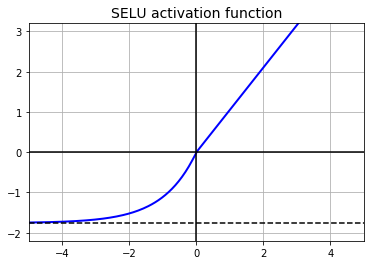

In [9]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

<h1><center>SELU Conditions</center></h1>

- There are a few conditions for self-normalization of SELU to happen:
    - The input features must be standardized (mean 0 and standard deviation 1).
    
    - Every hidden layer’s weights must be initialized with LeCun normal initialization. In Keras, this means setting `kernel_initializer="lecun_normal"`.
    
    - The network’s architecture must be sequential.
    
    - If you try to use SELU in nonsequential architectures, such as RNNs or networks with skip connections (i.e., connections that skip layers, such as in Wide & Deep nets), self-normalization will not be guaranteed, so SELU will not necessarily outperform other activation functions.
    
    - The paper only guarantees self-normalization if all layers are dense, but some researchers have noted that the SELU activation function can improve performance in Convolutional Neural Nets (CNNs) as well

<h1><center>Batch Normalization</center></h1>

- There is yet another technique to address **vanishing/exploding gradients** problems.


- The **Batch Normalization (BN)** technique consists of adding an operation in the model just before or after the activation function of each hidden layer.


- This operation simply zero-centers and normalizes each input, then scales and shifts the result using two new parameter vectors per layer: one for scaling, the other for shifting. In other words, the operation lets the model learn the optimal scale and mean of each of the layer’s inputs.


- So during training, BN standardizes its inputs, then rescales and offsets them.

**Equation 11-3: Batch Normalization algorithm** - Optional Reading from textbook

$
\begin{split}
1.\quad & \mathbf{\mu}_B = \dfrac{1}{m_B}\sum\limits_{i=1}^{m_B}{\mathbf{x}^{(i)}}\\
2.\quad & {\mathbf{\sigma}_B}^2 = \dfrac{1}{m_B}\sum\limits_{i=1}^{m_B}{(\mathbf{x}^{(i)} - \mathbf{\mu}_B)^2}\\
3.\quad & \hat{\mathbf{x}}^{(i)} = \dfrac{\mathbf{x}^{(i)} - \mathbf{\mu}_B}{\sqrt{{\mathbf{\sigma}_B}^2 + \epsilon}}\\
4.\quad & \mathbf{z}^{(i)} = \gamma \hat{\mathbf{x}}^{(i)} + \beta
\end{split}
$

In [10]:
# The authors of the BN paper argued in favor of adding the BN layers before the activation functions,
# rather than after.
# There is some debate about this, as which is preferable seems to depend on the task,
# so you can experiment with this too to see which option works best on your dataset.
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1

<h1><center>Gradient Clipping</center></h1>

- Another popular technique to mitigate the **exploding gradients** problem is to clip the gradients during backpropagation so that they never exceed some threshold. This is called Gradient Clipping.


- This technique is most often used in recurrent neural networks RNNs, as **Batch Normalization** is tricky to use in RNNs.

<h1><center>Gradient Clipping</center></h1>

<center><img src="img/gradient-clipping.png" align="center"/></center>

In [ ]:
# All Keras optimizers accept clipnorm or clipvalue arguments:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

optimizer = keras.optimizers.SGD(clipnorm=1.0)

<h1><center>Transfer Learning</center></h1>

- It is generally not a good idea to train a very large DNN from scratch: instead, you should always try to find an existing neural network that accomplishes a similar task to the one you are trying to tackle, then reuse the lower layers of this network. This technique is called **transfer learning**.

- It will not only speed up training considerably, but also require significantly less training data.

<center><img src="img/transfer-learning.png" align="center"/></center>

<font size='1'>Image from Ref[1]</font>

<h1><center>Unsupervised Pretraining</center></h1>

- Suppose you want to tackle a complex task for which you don’t have much labeled training data, but unfortunately you cannot find a model trained on a similar task.


- If you can gather plenty of unlabeled training data, you can try to use it to train an unsupervised model, such as an autoencoder or a Generative Adversarial Network (GAN).


- Then you can reuse the lower layers of the autoencoder or the lower layers of the GAN’s discriminator, add the output layer for your task on top, and fine- tune the final network using supervised learning (i.e., with the labeled training examples).

<h1><center>Unsupervised Pretraining</center></h1>

<center><img src="img/unsupervised-pretraining.png" align="center"/></center>

<font size='1'>Image from Ref[1]</font>

<h1><center>Momentum Optimization</center></h1>

- Imagine a bowling ball rolling down a gentle slope on a smooth surface: it will start out slowly, but it will quickly pick up momentum until it eventually reaches terminal velocity (if there is some friction or air resistance).


- This is the very simple idea behind **momentum optimization**, proposed by Boris Polyak in 1964.


- In contrast, regular Gradient Descent will simply take small, regular steps down the slope, so the algorithm will take much more time to reach the bottom.

<h1><center>Momentum Optimization Cont.</center></h1>

- Momentum optimization cares a great deal about what previous gradients were: at each iteration, it subtracts the local gradient from the momentum vector m (multiplied by the learning rate η), and it updates the weights by adding this momentum vector (see Equation 11-4).


- In other words, the gradient is used for acceleration, not for speed. To simulate some sort of friction mechanism and prevent the momentum from growing too large, the algorithm introduces a new hyperparameter β, called the momentum, which must be set between 0 (high friction) and 1 (no friction). A typical momentum value is 0.9.

**Equation 11-4: Momentum algorithm**

1. $\mathbf{m} \gets \beta \mathbf{m} - \eta \nabla_\boldsymbol{\theta}J(\boldsymbol{\theta})$
2. $\boldsymbol{\theta} \gets \boldsymbol{\theta} + \mathbf{m}$

<h1><center>Momentum Optimization</center></h1>

<center><img src="img/momentum.png" align="center"/></center>

<font size='1'>Image from Ref[1]</font>

<h1><center>AdaGrad</center></h1>

<center><img src="img/adagrad.png" align="center"/></center>

<font size='1'>Image from Ref[1]</font>

<h1><center>Optimizers Summary</center></h1>

<center><img src="img/optimizer-table.png" align="center"/></center>

<font size='1'>Image from Ref[1]</font>

<h1><center>Optimizers Demo</center></h1>

https://www.deeplearning.ai/ai-notes/optimization/

<h1><center>Learning Rate Scheduling</center></h1>

- See different scheduling techniques (power scheduling, exponential scheduling, 1cycle scheduling, etc.) in [Ch-11 notebook](https://github.com/ageron/handson-ml2/blob/master/11_training_deep_neural_networks.ipynb).

<center><img src="img/learning-rate.png" align="center"/></center>

<font size='1'>Image from Ref[1]</font>

<h1><center>Regularization</center></h1>

- Deep neural networks typically have tens of thousands of parameters, sometimes even millions. This gives them an incredible amount of freedom and means they can fit a huge variety of complex datasets.


- However, this great flexibility also makes the network prone to **overfitting** the training set. **Regularization** is required to avoid **overfitting**.


- We already implemented one of the best regularization techniques: **early stopping**.


- Moreover, even though **Batch Normalization** was designed to solve the unstable gradients problems, it also acts like a pretty good regularizer.


- Just like regularization can be applied for simple linear models, you can use l2 regularization to constrain a neural network’s connection weights, and/or l1 regularization if you want a sparse model (with many weights equal to 0).

In [ ]:
# Regularization
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
# or l1(0.1) for ℓ1 regularization with a factor or 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

<h1><center>Dropout</center></h1>

<center><img src="img/dropout.png" align="center"/></center>

<font size='1'>Image from Ref[1]</font>

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

<h1><center>Coming Up Next: Convolutional Neural Networks</center></h1>

<h1><center>References</center></h1>

[1] Hands-On ML Textbook Edition-2 2019